# 生成波形模板



In [88]:
from data_utils import *
from plot import *

### importing the library
from __future__ import print_function
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import signal

# import matplotlib.pyplot as plt
# %matplotlib inline 

import os, sys, time

# for auto-re00loading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 考察目标 GW 波形的质量分布

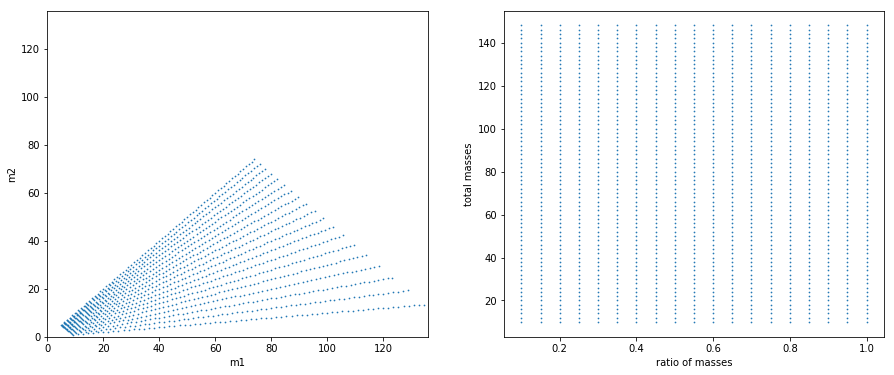

共有: 1330


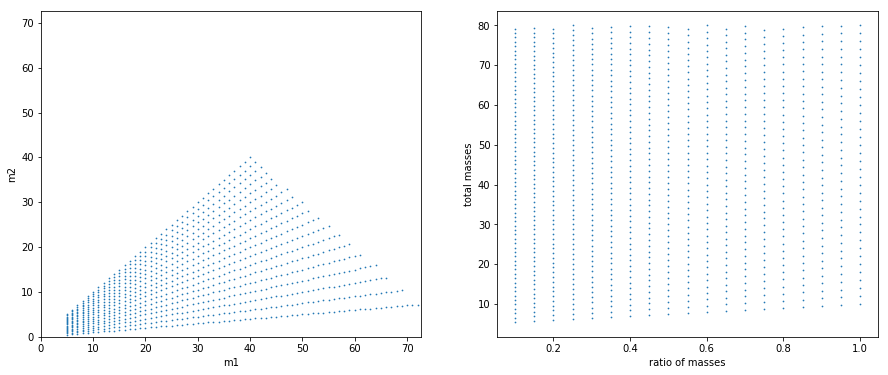

共有: 931


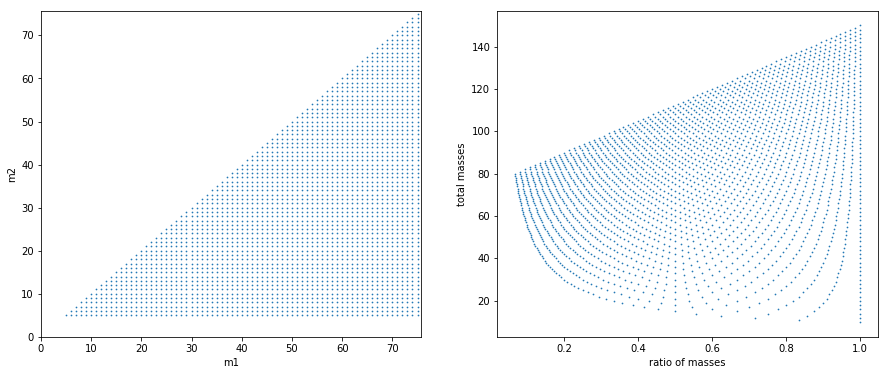

共有: 2556


In [69]:
masses = Distribution_of_masses(Mass_scope = (10, 150), Mass_step = 2, ratio_scope = (0.1, 1), ratio_step = 0.05)
Plot_masses_scratch(masses)
print('共有:', len(masses)) # masses 是一个 list
masses = Distribution_of_masses(mass1_scope = (5,80), mass_step = 1, ratio_scope = (0.1,1), ratio_step = 0.05)
Plot_masses_scratch(masses)
print('共有:', len(masses)) # masses 是一个 list
masses = Distribution_of_masses(mass1_scope = (5,75), mass2_scope = (5,75), mass_step = 1)
Plot_masses_scratch(masses)
print('共有:', len(masses)) # masses 是一个 list

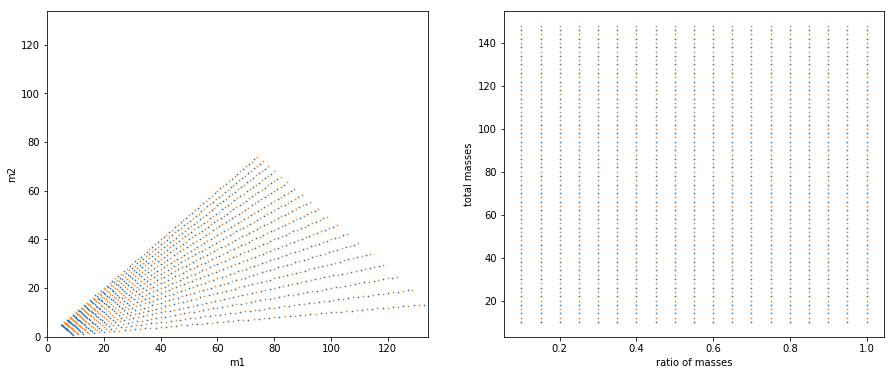

In [102]:
masses = Distribution_of_masses(Mass_scope = (10, 150), Mass_step = 2, ratio_scope = (0.1, 1), ratio_step = 0.05)
masses_train = [(m1,m2) for (m1, m2) in masses if m1 + m2 in range(10, 150, 4)]
masses_test = [(m1,m2) for (m1, m2) in masses if m1 + m2 in range(12, 150, 4)]
Plot_masses_scratch(masses_train, masses_test)

### For preprint

共有: 1974


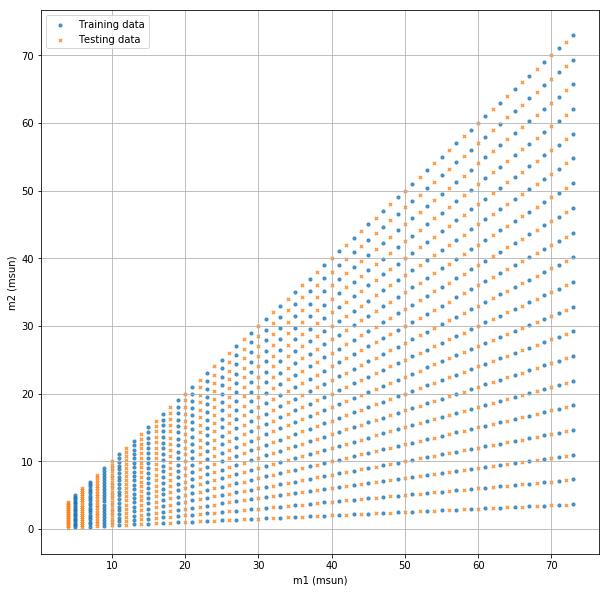

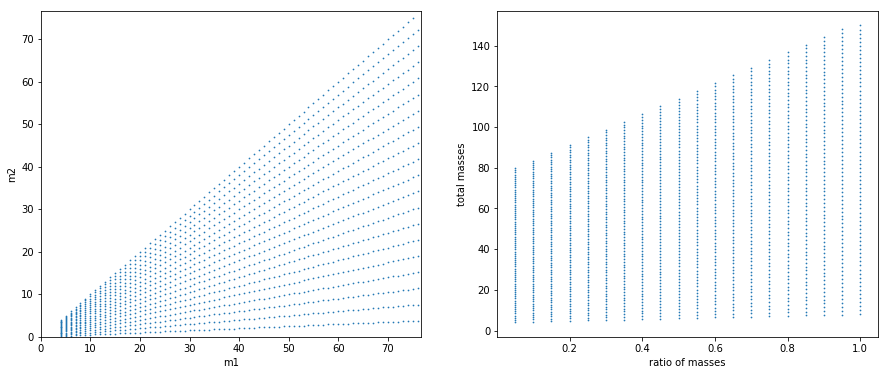

In [112]:
masses = Distribution_of_masses(mass1_scope = (4,150), mass_step = 1, ratio_scope = (0.05,1), ratio_step = 0.05)
print('共有:', len(masses)) # masses 是一个 list
masses_train = [(m1,m2) for (m1, m2) in masses if (m1 in range(5, 75, 2)) and (m1  <= 76)]
masses_test = [(m1,m2) for (m1, m2) in masses if (m1 in range(4, 74, 2)) and (m1  <= 76)]

plt.figure(figsize=(10,10))
plt.scatter(np.array(masses_train)[:,0], np.array(masses_train)[:,1], s=10, alpha=0.75, label = 'Training data')
plt.scatter(np.array(masses_test)[:,0], np.array(masses_test)[:,1], s=10, alpha=0.75, label= 'Testing data', marker = 'x')
plt.grid()
plt.xlabel('m1 (msun)')
plt.ylabel('m2 (msun)')
# plt.xlim(0, np.array(masses_train).max()*(1+0.01))
# plt.ylim(0, np.array(masses_train).max()*(1+0.01))
plt.legend()
plt.savefig('./images/paper1.png', dpi = 300, bbox_inches = 'tight')

Plot_masses_scratch([(m1, m2) for m1, m2 in masses if m1  <= 76])

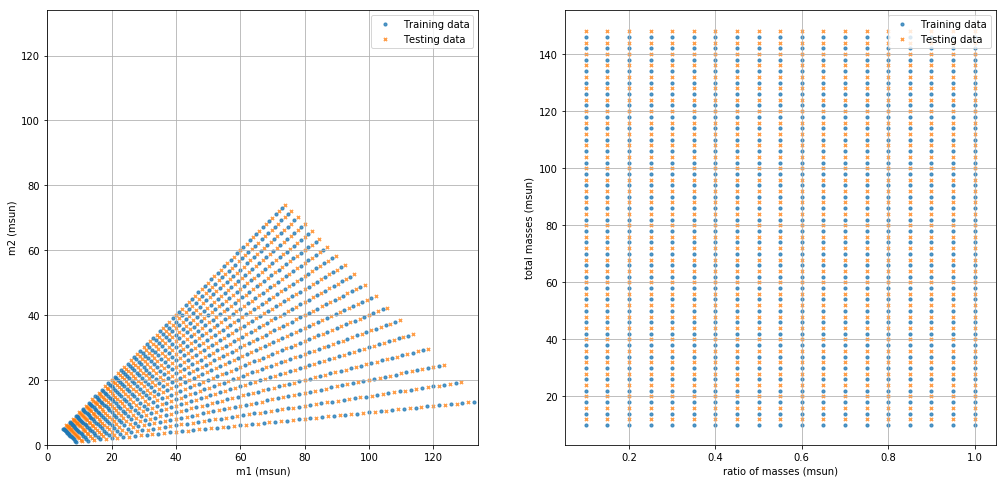

In [126]:
masses = Distribution_of_masses(Mass_scope = (10, 150), Mass_step = 2, ratio_scope = (0.1, 1), ratio_step = 0.05)
masses_train = np.array([(m1,m2) for (m1, m2) in masses if m1 + m2 in range(10, 150, 4)])
masses_test = np.array([(m1,m2) for (m1, m2) in masses if m1 + m2 in range(12, 150, 4)])

plt.figure(figsize=(17,8))
plt.subplot(1,2,1)
plt.scatter(masses_train[:,0], masses_train[:,1], s=10, alpha=0.75, label = 'Training data')
plt.scatter(masses_test[:,0], masses_test[:,1], s=10, alpha=0.75, label= 'Testing data', marker = 'x')
plt.grid()
plt.xlabel('m1 (msun)')
plt.ylabel('m2 (msun)')
plt.xlim(0, np.array(masses_train).max()*(1+0.01))
plt.ylim(0, np.array(masses_train).max()*(1+0.01))
plt.legend()

plt.subplot(1,2,2)
plt.scatter(masses_train[:,1]/masses_train[:,0], masses_train[:,0] + masses_train[:,1], s=10, alpha=0.75, label = 'Training data')
plt.scatter(masses_test[:,1]/masses_test[:,0], masses_test[:,0] + masses_test[:,1], s=10, alpha=0.75, label= 'Testing data', marker = 'x')
plt.xlabel('ratio of masses (msun)'), plt.ylabel('total masses (msun)')
plt.grid()
plt.legend()
# plt.savefig('./images/m1m2.png')
plt.show()

## 生成GW波形

In [85]:
!./Panyi_code/Panyi --help

Generate a simulation using the lalsimulation library

The following options can be given (will assume a default value if omitted):
--amp-phase                If given, will output:
                           |h+ - i hx|, Arg(h+ - i hx) (TD) or
                           |h+(f)|, Arg(h+(f)), |hx(f)|, Arg(hx(f)) (FD)
                           If not given, will output h+ and hx (TD and FD)
                           NOTE: Other approximants may be available if the
                           developer forgot to edit this help message
--amp-order ORD            Twice PN order of amplitude (default 0 <==> Newt.)
--phiRef phiRef            Phase at the reference frequency (default 0)
                           (default: 0)
--sample-rate SRATE        Sampling rate of TD approximants in Hz (default 4096)
--m1 M1                    Mass of the 1st object in solar masses (default 10)
--m2 M2                    Mass of the 2nd object in solar masses (default 1.4)
--inclination IOTA         Angl

In [106]:
def GenGW(masses, T = 1, fs = 8192, peak_time = 0.8, time_shuffle = [0], f_min = 20, temp_file = 'test.dat'):
    """
    生成引力波波形. 
    注意: 要求该函数执行时，Panyi 的程序文件夹相对路径位于: '../Panyi_code/Panyi'
         可以通过终端命令 '../Panyi_code/Panyi --help' 来检查.

    Input:
    - masses: A list. 其中的元素是双黑洞质量对组成的元组. Eg: [(5,5),(10,10),(15,15)]. 需配合 Distribution_of_masses 函数.
    - T: 信号波形的时长[s]. 默认为1s.
    - fs: 信号的采样率[Hz]. 默认为8192Hz. (注: N = T * fs, N 必须能被2整除)
    - peak_time: 自起始位置起, 波形信号最大峰值所对应的时间[s]. 默认为0.8s. 主要搭配 time_shuffle 参数使用.
    - time_shuffle: A list. 默认为[0], 其中的列表元素表示偏离 peak_time 的时间差[s]. 
                    (生成波形的次序依据偏离时间差的绝对值有小到大顺序)
    - f_min: Int. 默认值为20[Hz]. 表示从 Panyi 程序中生成GW波形的最小频率.(Lower frequency to start waveform in Hz)
             (若因 f_min 过大使得处理后的信号不够 N, 会 f_min-=5 重新循环生成波形, 直到达到需求)
    - temp_file: Str. 默认值为'test.dat'. 该函数运行过程中会在本地目录中缓存的文件名(最终会自动清理删除)
    
    Output:
    - data: DataFrame. GW 波形信号构成的表格, index 是 GW 波形对应的双黑洞质量.
    """
    N = int(T * fs)
    time_shuffle.sort(key = abs)
    
    assert N % 2 ==0 and fs % 2 == 0
    print('({t:s})'.format(t=time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time()))))
    
    # 初始化
    index = 0
    index_timeshuffle = 0
    fmin = f_min
    data = pd.DataFrame(np.array([]))  
    peaktime = peak_time + time_shuffle[index_timeshuffle]
    peakpoint = int(peaktime * N)
    
    while True:
        try:
            m1, m2 = masses[index]
        except IndexError: # 全部 masses 穷尽后退出循环
            break
            
        # 每个信号生成前的时间戳和进度提示
        stamp = '({t:s}) Working on masses=({m1:.2f}|{m2:.2f}) with fmin={fmin:d} (complete percent: {percent:.2f}/100)'.format(t=time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())), m1=m1, m2=m2,fmin=fmin, percent=1.0 * index / len(masses) * 100)
        print(stamp, end='')

        os.system('./Panyi_code/Panyi --m1 {m1:.2f} --m2 {m2:.2f} --sample-rate {fs:d} --f-min {fmin:d} --outname {file:s}'.format(m1=m1, m2=m2, fs=fs, fmin=fmin, file=temp_file))
        
        try:
            temp = pd.DataFrame(np.loadtxt(temp_file))
        except FileNotFoundError as e:
            print(e)

        while True:
            # 固定最大峰值位置为第peakpoint个采样点
            posmax = temp[1].argmax()
            part1 = temp[1][posmax-peakpoint+1:]
            part1 = pd.Series(part1.values, index=range(1, len(part1)+1))
            lenpart1 = len(part1)
            if lenpart1 < N:
                lenpart2 = N - part1.shape[0]
                part2 = pd.Series(list([part1.values[-1]]) *lenpart2, index=range(lenpart1+1, lenpart1+1+lenpart2))
                temp_ = part1.append(part2, ignore_index = False, verify_integrity = True)
            else:
                temp_ = part1[:N]
            
            try:
                # 查验
                assert temp_.argmax() == peakpoint   # 如果test的max不够peakpoint, 终止载入，做好标记~
            except AssertionError: # Panyi给出并处理后的temp_有可能不够N个
                print()
                print('The number of GW_sample ({m1:.2f}|{m2:.2f}) with fmin={fmin:d} peaktime={peaktime:.2f}s cannot be {N:d}!'.format(m1=m1,m2=m2,fmin=fmin, peaktime=peaktime,N=N))
                fmin -= 5
                break

            # 删除本地备份文件
            os.system('rm {file:s}'.format(file=temp_file))
            
            # 保存
            data = pd.concat([data, pd.DataFrame([temp_.values], index=['{m1:.2f}|{m2:.2f}'.format(m1=m1,m2=m2)])])
            sys.stdout.write("\r")                
            try:
                # 更新 peakpoint
                index_timeshuffle += 1
                assert len(time_shuffle) > index_timeshuffle
            except AssertionError: # timeshuffle没有值可用的时候结束循环跳出
                index_timeshuffle = 0
                index += 1    
                fmin = f_min
                break
            finally:
                peaktime = peak_time + time_shuffle[index_timeshuffle]
                peakpoint = int(peaktime * N)
    print('Finished!')
    return data

In [87]:
%%time
masses = Distribution_of_masses(Mass_scope = (10, 150), Mass_step = 2, ratio_scope = (0.1, 1), ratio_step = 0.05)
data = GenGW(masses ,peak_time = 0.05, time_shuffle = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# CPU times: user 2h 7min 22s, sys: 55min 12s, total: 3h 2min 35s
# Wall time: 4h 36min 13s

(2018-08-12 12:28:45)
(2018-08-12 13:30:39) Working on masses=(29.00|29.00) with fmin=20 (complete percent: 25.64/100)
The number of GW_sample (29.00|29.00) with fmin=20 peaktime=0.95s cannot be 8192!
(2018-08-12 13:32:27) Working on masses=(29.74|28.26) with fmin=20 (complete percent: 26.54/100)
The number of GW_sample (29.74|28.26) with fmin=20 peaktime=0.95s cannot be 8192!
(2018-08-12 13:33:19) Working on masses=(30.00|30.00) with fmin=20 (complete percent: 26.92/100)
The number of GW_sample (30.00|30.00) with fmin=20 peaktime=0.85s cannot be 8192!
(2018-08-12 13:34:02) Working on masses=(30.53|27.47) with fmin=20 (complete percent: 27.29/100)
The number of GW_sample (30.53|27.47) with fmin=20 peaktime=0.95s cannot be 8192!
(2018-08-12 13:34:39) Working on masses=(30.77|29.23) with fmin=20 (complete percent: 27.59/100)
The number of GW_sample (30.77|29.23) with fmin=20 peaktime=0.95s cannot be 8192!
(2018-08-12 13:35:16) Working on masses=(31.00|31.00) with fmin=20 (complete percen

In [88]:
%%time

np.save('GW', data.values)
np.save('GW_index', data.index.values)
!ls -lh GW.npy
!ls -lh GW_index.npy

-rw-r--r--  1 Herb  staff   831M Aug 12 17:05 GW.npy
-rw-r--r--  1 Herb  staff   270K Aug 12 17:05 GW_index.npy
CPU times: user 194 ms, sys: 8 s, total: 8.19 s
Wall time: 9.59 s


In [89]:
%%time

tt = np.load('GW.npy')
tt_ = np.load('GW_index.npy')

CPU times: user 7.18 ms, sys: 983 ms, total: 990 ms
Wall time: 1.49 s


In [90]:
data = pd.DataFrame(tt, index=tt_)
print(data.shape)
data.head()

(13300, 8192)


,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
5.00|5.00,-5.919231e-22,-6.160910e-22,-6.296472e-22,-6.323189e-22,-6.240207e-22,-6.048574e-22,-5.751237e-22,-5.353001e-22,-4.860459e-22,-4.281887e-22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.00|5.00,-3.283272e-22,-2.938338e-22,-2.569290e-22,-2.179099e-22,-1.770915e-22,-1.348042e-22,-9.139055e-23,-4.720332e-23,-2.601992e-24,4.204986e-23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.00|5.00,4.111777e-22,4.217280e-22,4.298880e-22,4.356093e-22,4.388578e-22,4.396132e-22,4.378692e-22,4.336340e-22,4.269298e-22,4.177929e-22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.00|5.00,-9.042932e-23,-6.373467e-23,-3.674736e-23,-9.587949e-24,1.762212e-23,4.476108e-23,7.170742e-23,9.834036e-23,1.245404e-22,1.501901e-22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.00|5.00,-2.991239e-22,-3.132659e-22,-3.262402e-22,-3.379979e-22,-3.484945e-22,-3.576902e-22,-3.655501e-22,-3.720442e-22,-3.771477e-22,-3.808408e-22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
# 检查是否有 NULL
True in data.isnull().values

False

['27.78|22.22']


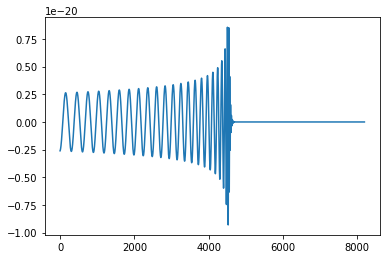

In [92]:
# 波形随机抽样预览
t = data.sample(1)
print(t.index.values)
plt.plot(t.values[0])
plt.show()

In [93]:
# 检查波形峰值点
pd.Series([data.iloc[i,].argmax() for i in range(data.shape[0])]).value_counts()

2047    1330
7781    1330
6143    1330
3685    1330
1227    1330
2866    1330
4504    1330
5323    1330
6962    1330
408     1330
dtype: int64

``` Python
from random import sample as love_from_boss

while luck not in my_life:
    
    if holiday and love_from_boss([0]*364+[1],1)[0]:
        print('Happiness!')
        My_life_my_choice(max_power=True, sleep_24h = True)
        
    wakeup()
    breakfasts()
    woking()
    
    lunch()
    try:
        sleep(1)
        lifespan += 1
        bonus -= 100
    except:
        lifespan -= 1
    woking()

    try:
        bodyshaping()
        bodyweight -= 100
    except:
        bodyweight += 100
    supper()
    
    while not luck:
        try:
            submit(mywork)
        except Exception as e:
            print('Boss: What is this shit?!',e)
            print('Boss: So! Go fxxk yourself, {:s}！'.format(myname))
            overworking()            
        else:
            sleeping(until = 7)
            break
        finally:
            lifespan -= 10
        if lifespan <=0: 
            dead()
            print('Game over')
            break
```